In [1]:
import torch
from torch import nn
import numpy as np

def MAE(output, target):
    return torch.mean(torch.abs(output - target))

def test(model, test_loader, f_dim, device, pred_len=360, ft=True, args=None):

    model.to(device)
    criterion_se = nn.MSELoss()
    criterion_mse = nn.MSELoss()
    criterion_mae = MAE

    with torch.no_grad():
        model.eval()
        test_loss_se=[]
        test_loss_mse = []
        test_loss_mae = []
        i = 0
        for i, (batch_x, batch_y, *_) in enumerate(test_loader):
            batch_x = batch_x.float().to(device)
            batch_y = batch_y.float().to(device)[:, -pred_len:, :]
            batch_xy = torch.cat([batch_x, batch_y], dim=1).to(device)
            output = model(batch_x)
            if ft:
                output = output[:, -pred_len:, f_dim:]
                batch_y = batch_y[:, -pred_len:, f_dim:].to(device)
                loss_se = criterion_se(output[:,-1,:], batch_y[:,-1,:])
                loss_mse = criterion_mse(output, batch_y)
                loss_mae = criterion_mae(output, batch_y)
            else:
                output = output[:, :, f_dim:]
                loss_mse = criterion_mse(output, batch_xy)
                loss_mae = criterion_mae(output, batch_xy)

            
            test_loss_se.append(loss_se.item())
            test_loss_mse.append(loss_mse.item())
            test_loss_mae.append(loss_mae.item())
            i += 1
            if i == 50 and args.model == "ARIMA":
                break

        print(
            f"Test loss SE (mean from {i} batches) {np.mean(test_loss_se):.4f} Test loss MSE: {np.mean(test_loss_mse):.4f}, Test loss MAE: {np.mean(test_loss_mae):.4f}"
        )
        print("args =", args)

    return model, np.mean(test_loss_mse), output, batch_xy, batch_x, batch_y

In [2]:
import torch
from FITS_datahandling.data_factory import data_provider
from models.FITS_padding import FITS
from argparse import Namespace

args = Namespace(root_path='data', dataset='GD', debug=False, target_columns=['OT'], all_cols=True, epochs=50, batch_size=64, test_size=0.1, normalize=True, seq_len=720, num_layers=1, num_hidden=64, label_len=48, pred_len=720, individual=False, upsample_rate=0, channels=7, dominance_freq=196, augment_data=False,  aug_method='f_mix', features='M', use_wandb=False, ft=False, train_and_finetune=True, H_order=6, base_T=24, use_real_FITS=False, use_original_datahandling=True,  test_only=False, model='FITS_padding', save_state_dict=True, use_deep=False, data='GD', target=['OT'], data_size=1, test_time_train=False,  in_batch_augmentation=False, in_dataset_augmentation=False, num_workers=8, freq='h', data_path='gd.csv')

model = FITS(args)  # Replace *args and **kwargs with the appropriate arguments for your model
saved_model = "model_FITS_padding_data_GD_pred720__pred__epochs50.pth"
state_dict = torch.load(f'../src/saved_models/{saved_model}')
model.load_state_dict(state_dict)

test_data, test_loader = data_provider(args, "test")

model, test_mse, output, batch_xy, batch_x, batch_y= test(
    model=model,
    test_loader=test_loader,
    pred_len=args.pred_len,
    f_dim=-1 if args.features == "MS" else 0,
    device="cpu",
    ft=True,
    args=args,
)


Length of test set: 2425
Test loss SE (mean from 38 batches) 31.5735 Test loss MSE: 11.9255, Test loss MAE: 2.5983
args = Namespace(root_path='../data', dataset='GD', debug=False, target_columns=['OT'], all_cols=True, epochs=50, batch_size=64, test_size=0.1, normalize=True, seq_len=720, num_layers=1, num_hidden=64, label_len=48, pred_len=720, individual=False, upsample_rate=0, channels=7, dominance_freq=196, augment_data=False, aug_method='f_mix', features='M', use_wandb=False, ft=False, train_and_finetune=True, H_order=6, base_T=24, use_real_FITS=False, use_original_datahandling=True, test_only=False, model='FITS_padding', save_state_dict=True, use_deep=False, data='GD', target=['OT'], data_size=1, test_time_train=False, in_batch_augmentation=False, in_dataset_augmentation=False, num_workers=8, freq='h', data_path='GD.csv')


In [3]:
batch_x = batch_x[0, :, 0].clone().unsqueeze(0).unsqueeze(-1)
batch_y = batch_y[0, :, 0].clone().unsqueeze(0).unsqueeze(-1)
batch_xy = batch_xy[0, :, 0].clone().unsqueeze(0).unsqueeze(-1)


In [4]:
pred_len = args.pred_len
seq_len = args.seq_len
cutoff_freq = args.dominance_freq
epochs = args.epochs

from models.ARIMA import ARIMA
from models.baseline import NaiveForecast
from models.baseline import AverageForecast
from parser import parser # type: ignore    

# Initialize the baseline models and FITS
args_ = parser.parse_args(["--pred_len", str(pred_len), "--seq_len", str(seq_len), "--debug"])
arima = ARIMA(args_)
naive = NaiveForecast(args_)
average = AverageForecast(args_)

def RMAE(output, target):
    return torch.sqrt(torch.mean(torch.abs(output - target)))

criterion_mse = nn.MSELoss()


# Naive Forecast
with torch.no_grad():
    output_naive = naive(batch_x)
    if type(output_naive) == torch.tensor: output_naive = output_naive.detach().numpy()
    output_naive = output_naive[:, -pred_len:, :]
    loss_mse_naive = criterion_mse(output_naive, batch_y)

# Average Forecast
with torch.no_grad():
    output_average = average(batch_x)
    if type(output_average) == torch.tensor: output_average = output_average.detach().numpy()
    output_average = output_average[:, -pred_len:, 0:]
    loss_mse_average = criterion_mse(output_average, batch_y)

# ARIMA Forecast
with torch.no_grad():
    output_arima, best_model = arima(batch_x)
    output_arima = output_arima.to(batch_y.device)
    if type(output_arima) == torch.tensor: output_arima = output_arima.detach().numpy()
    output_arima = output_arima[:, -pred_len:, 0:]
    loss_mse_arima= criterion_mse(output_arima, batch_y)

# FITS + ARIMA 
with torch.no_grad(): # not necessary but looks better
    output_arima_fits = output + output_arima - torch.mean(output)
    loss_mse_arima_fits = criterion_mse(output_arima_fits, batch_y)

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

dataset = args.data
df = pd.read_csv(f"../data/{dataset}.csv")
df

,Date,Open,High,Low,Close,Volume,Adj Close
0,1962-01-02,0.000000,0.753125,0.728125,0.746875,2648000,0.174832
1,1962-01-03,0.000000,0.781250,0.753125,0.771875,2092000,0.180684
2,1962-01-04,0.000000,0.806250,0.771875,0.775000,2884000,0.181415
3,1962-01-05,0.000000,0.793750,0.775000,0.778125,1532000,0.182147
4,1962-01-08,0.000000,0.793750,0.765625,0.790625,1676000,0.185073
...,...,...,...,...,...,...,...
15719,2024-06-13,293.679993,294.570007,290.730011,292.519989,686600,292.519989
15720,2024-06-14,290.700012,292.040009,288.459991,291.779999,639900,291.779999
15721,2024-06-17,291.179993,294.190002,290.660004,293.829987,511000,293.829987
15722,2024-06-18,293.570007,298.049988,293.170013,298.000000,748500,298.000000


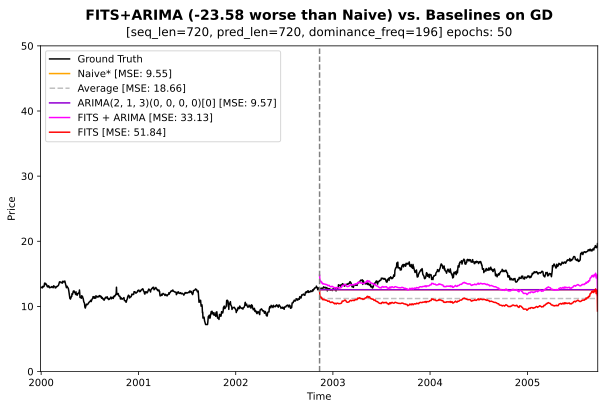

In [7]:
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
import pandas as pd
import numpy as np

%matplotlib inline
set_matplotlib_formats('svg')

dataset = args.data # dataset name
df = pd.read_csv(f"../data/{dataset}.csv")
df["Date"] = pd.to_datetime(df["Date"])
test_start_index = 9567 - seq_len + pred_len

plt.figure(figsize=(10, 6))
ax = plt.gca()

seq_len = batch_xy.shape[1] - pred_len

# Adjust x-values for the ground truth and prediction
x_history = df["Date"].iloc[test_start_index:test_start_index + seq_len]
x_forecast = df["Date"].iloc[test_start_index + seq_len:test_start_index + seq_len + pred_len]

ax.plot(x_history, batch_xy[0, :seq_len, 0].cpu().numpy(), color="black", label="Ground Truth")
ax.plot(x_forecast, batch_y[0, :, 0].cpu().numpy(), color='black')

baselines = [
    ("Naive", output_naive, criterion_mse(output_naive, batch_y), 'orange', '-'),
    ("Average", output_average, criterion_mse(output_average, batch_y), 'silver', '--'),
    (best_model[0], output_arima, criterion_mse(output_arima, batch_y), 'darkviolet', '-'),
    ("FITS + ARIMA", output_arima_fits, loss_mse_arima_fits, 'magenta', '-'),
    ("FITS", output, criterion_mse(output, batch_y), 'red', '-')
]

for name, output_data, mse, color, linestyle in baselines:
    mse_ = round(mse.item(), 2)
    ax.plot(x_forecast, output_data[0, :, 0].cpu().numpy(),
            label=f"{name}* [MSE: {mse_}]" if mse == min(loss_mse_arima, loss_mse_naive, loss_mse_average) else f"{name} [MSE: {mse_}]", linestyle=linestyle, color=color)

best = min(criterion_mse(output_naive, batch_y), criterion_mse(output_average, batch_y), criterion_mse(output_arima, batch_y))
second_best_name = next(name for name, _, mse, _, _ in baselines if mse == best)
improvement = best - loss_mse_arima_fits

ax.legend(loc="upper left")
ax.axvline(x=df["Date"].iloc[test_start_index + seq_len], color="gray", linestyle="--", label="Forecast Start")

ax.set_title(" ", fontsize=40)
ax.text(0.5, 1.08, f"""FITS+ARIMA ({'+' if round(improvement.item(), 2) >= 0 else '-'}{abs(round(improvement.item(), 2))} {'better' if round(improvement.item(), 2) >= 0 else 'worse'} than {second_best_name}) vs. Baselines on {args.data}""", fontsize=14, ha='center', fontweight='bold', transform=ax.transAxes)
ax.text(0.5, 1.03, f"""[seq_len={seq_len}, pred_len={pred_len}, dominance_freq={cutoff_freq}] epochs: {epochs}""", fontsize=12, ha='center', transform=ax.transAxes)

ax.set_ylabel("Price")
ax.set_xlabel("Time")

ax.set_xlim(df["Date"].iloc[test_start_index], df["Date"].iloc[test_start_index + seq_len + pred_len])
ax.set_ylim(0, 50)

plt.show()

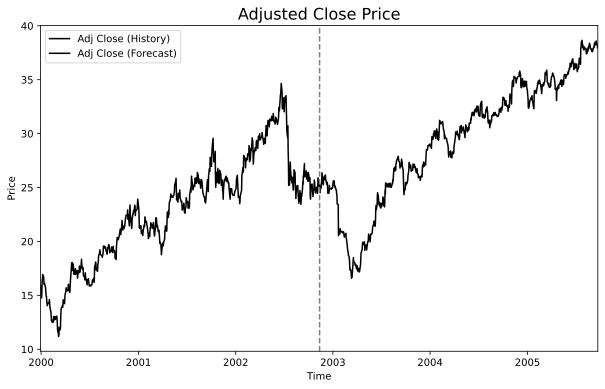

In [8]:
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
import pandas as pd
import numpy as np

%matplotlib inline
set_matplotlib_formats('svg')

dataset = args.data  # dataset name
df = pd.read_csv(f"../data/{dataset}.csv")
df["Date"] = pd.to_datetime(df["Date"])
test_start_index = 9567 - seq_len + pred_len

plt.figure(figsize=(10, 6))
ax = plt.gca()

seq_len = batch_xy.shape[1] - pred_len

# Adjust x-values for the ground truth and prediction
x_history = df["Date"].iloc[test_start_index:test_start_index + seq_len]
x_forecast = df["Date"].iloc[test_start_index + seq_len:test_start_index + seq_len + pred_len]

ax.plot(x_history, df["Adj Close"].iloc[test_start_index:test_start_index + seq_len], color="black", label="Adj Close (History)")
ax.plot(x_forecast, df["Adj Close"].iloc[test_start_index + seq_len:test_start_index + seq_len + pred_len], color='black', label="Adj Close (Forecast)")

ax.legend(loc="upper left")
ax.axvline(x=df["Date"].iloc[test_start_index + seq_len], color="gray", linestyle="--", label="Forecast Start")

ax.set_title("Adjusted Close Price", fontsize=16)

ax.set_ylabel("Price")
ax.set_xlabel("Time")

ax.set_xlim(df["Date"].iloc[test_start_index], df["Date"].iloc[test_start_index + seq_len + pred_len])

plt.show()

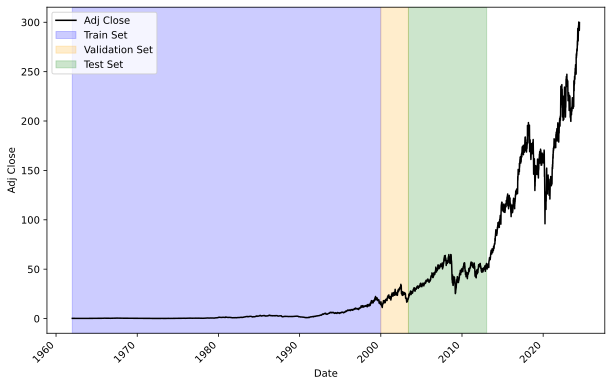

In [ ]:
# Calculate the lengths of each set
train_len = 9567
val_len = 855
test_len = 2425

# Calculate the total length of the data
total_len = train_len + val_len + test_len

# Create a new figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the 'Adj Close' data for the entire period
ax.plot(df["Date"], df["Adj Close"], color="black", label="Adj Close")

# Fill the background of each set with different colors
ax.axvspan(df["Date"].iloc[0], df["Date"].iloc[train_len], alpha=0.2, color='blue', label='Train Set')
ax.axvspan(df["Date"].iloc[train_len], df["Date"].iloc[train_len + val_len], alpha=0.2, color='orange', label='Validation Set')
ax.axvspan(df["Date"].iloc[train_len + val_len], df["Date"].iloc[total_len], alpha=0.2, color='green', label='Test Set')

# Set the x-axis label
ax.set_xlabel("Date")

# Set the y-axis label
ax.set_ylabel("Adj Close")

# Rotate the x-axis labels for better readability (optional)
plt.xticks(rotation=45, ha='right')

# Add a legend
ax.legend(loc='upper left')

# Show the plot
plt.show()